In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols= ["country", "description", "points", "price", "variety", "winery"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"]) # elimina las filas que tengan un dato NaN en esas cols

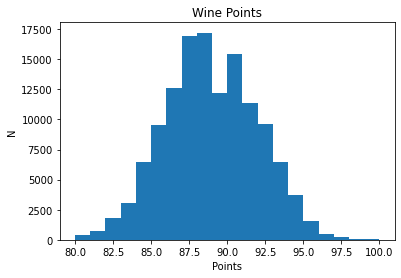

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Wine Points")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.34070754, -0.04310284, -0.01543818, ...,  0.05853154,
        -0.04221797,  0.0807843 ],
       [ 0.5664657 , -0.30241537,  0.0462991 , ...,  0.07533624,
        -0.11980586, -0.03976566],
       [ 0.37160757,  0.12706953,  0.01755041, ...,  0.06051275,
        -0.19221003,  0.01395175],
       ...,
       [ 0.21284379, -0.14839782, -0.16669773, ..., -0.03425581,
        -0.06103861, -0.05143104],
       [ 0.33204642, -0.12113712,  0.10393801, ..., -0.1336562 ,
        -0.08036801,  0.10302781],
       [ 0.36678022,  0.03587857, -0.28411207, ..., -0.10605042,
        -0.07038461, -0.0288075 ]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4)) # bc of overfeeding
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 2s 15ms/step - loss: 0.7124 - accuracy: 0.3772


[0.7123667001724243, 0.37716394662857056]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 14ms/step - loss: 0.7122 - accuracy: 0.3770


[0.7122211456298828, 0.3770100772380829]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 52s 501ms/step - loss: 0.6671 - accuracy: 0.6111 - val_loss: 0.5955 - val_accuracy: 0.7493
Epoch 2/5
102/102 [==============================] - 49s 484ms/step - loss: 0.5250 - accuracy: 0.7761 - val_loss: 0.4379 - val_accuracy: 0.8148
Epoch 3/5
102/102 [==============================] - 49s 477ms/step - loss: 0.4226 - accuracy: 0.8274 - val_loss: 0.3912 - val_accuracy: 0.8247
Epoch 4/5
102/102 [==============================] - 49s 476ms/step - loss: 0.3775 - accuracy: 0.8478 - val_loss: 0.3791 - val_accuracy: 0.8281
Epoch 5/5
102/102 [==============================] - 50s 487ms/step - loss: 0.3511 - accuracy: 0.8607 - val_loss: 0.3785 - val_accuracy: 0.8284


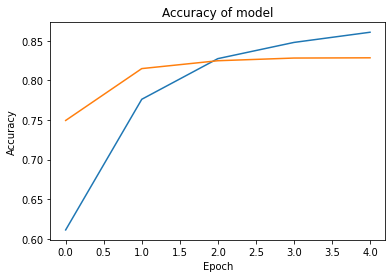

In [ ]:
plt.plot(history.history["accuracy"], label="Training acc")
plt.plot(history.history["val_accuracy"], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

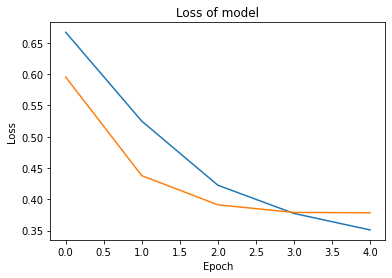

In [ ]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 1s 58ms/step - loss: 0.3696 - accuracy: 0.8337


[0.3695969879627228, 0.8337436318397522]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 168ms/step - loss: 0.6928 - accuracy: 0.5554


[0.6927611827850342, 0.5554358959197998]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 50s 440ms/step - loss: 0.5433 - accuracy: 0.7132 - val_loss: 0.3770 - val_accuracy: 0.8247
Epoch 2/5
102/102 [==============================] - 43s 425ms/step - loss: 0.3652 - accuracy: 0.8370 - val_loss: 0.3609 - val_accuracy: 0.8333
Epoch 3/5
102/102 [==============================] - 42s 410ms/step - loss: 0.3480 - accuracy: 0.8456 - val_loss: 0.3513 - val_accuracy: 0.8402
Epoch 4/5
102/102 [==============================] - 41s 404ms/step - loss: 0.3392 - accuracy: 0.8483 - val_loss: 0.3514 - val_accuracy: 0.8406
Epoch 5/5
102/102 [==============================] - 43s 418ms/step - loss: 0.3346 - accuracy: 0.8499 - val_loss: 0.3524 - val_accuracy: 0.8406
